# Bayesian differential abundance testing

The paper of [Kruschke (2013)](https://www.ncbi.nlm.nih.gov/pubmed/22774788) will be helpful before reading on. We used a similar approach to estimate whether there is a difference in the mean $\mu$ and the standard deviation $\sigma$ in that underly the distribution of the 130 genus level bacterial abudnances. We tried different approaches to model bacterial abundances and decided to use this approach because it remains easily interpretable and captures well the mean and standard deviation. Where it comes short is that it cannot model the skew well, which is present despite transforming the outcome. So, we can use it to answer questions like: "Do the means and the standard deviations differ between groups". To use the same notation as Kruschke, we can write the model where we have 4 groups (*home_pre* (1), *home_post* (2), *cc_pre* (3), *cc_post* (4) like this:  

$$y_{1i} \sim T(\nu, \mu_1, \sigma_1)$$  
$$y_{2i} \sim T(\nu, \mu_2, \sigma_2)$$  
$$y_{3i} \sim T(\nu, \mu_3, \sigma_3)$$  
$$y_{4i} \sim T(\nu, \mu_4, \sigma_4)$$ 

Alternatively, we can write:  
$$y_{i} \sim T(\nu, \mu, \sigma)$$ 

We model $\mu$ and $\sigma$ each as a linear function:  
$$\mu_i = \beta_{0i[j]} + \beta_{1} \times group + \beta_{2} \times time + \beta_{3} \times group \times time + \beta_{4} \times age + \beta_{5} \times breastfeeding + \beta_{6} \times sibling + \beta_{7} \times csection + \beta_{8} \times sibling \times csection$$   
$$\sigma_i = \beta_{\sigma 0} + \beta_{\sigma 1} \times group + \beta_{\sigma 2} \times time$$ 

The *j* in $\beta_{0i[j]}$ indicates that each subject can deviate from the overall mean but the individual mean is partially pooled an dragged towads the overall mean. The model will estimate the standard deviation around the overall mean and this gives some insight in individual variation among the infants. The prior specification is explained further below. We chose to include csection in the model because at that age it can have a strong influence on bacterial composition. Since 6 samples are from infants that were born via c-section in the home group as opposed to 12 samples from the cc group, we will compare the cc to home among those infants who are not born via c-section.

In [3]:
library(tidyverse)
library(glue)
library(brms)
library(furrr)
library(here)
library(future)
library(tidybayes)
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

In [4]:
load(here("rdata/data_mi.rds"))

## Prior specification
BRMS has reasonable standard prior specifications that can be checked as shown below. We deviated from that and applied a normal prior $N(0, 1)$ for all $\beta_i$. This way most probability is at the effect being 0 while all realistic effect size are considered by the model. This way we make the model more conservative compared to classic methods. See Gelman why this helps limit type S errors. Also we restrict how much $\sigma$ can vary between groups for each of the 3 coefficients but not for the intercept. Note that sigma is fit on the log scale automatically in brms and there again all realistic differences in this paramter that are naturally present in a similar population or that could arise from going in to CC vs HOME are considered. Finally, the prior on $\nu$ is a bit more constrained in the higher values than the standard prior. That helps the model to not consider very high $\nu$, which it would if the distribution is close to normal because then many $\nu$ are equally likely.

In [43]:
# define the formula we use at the example of Bifidobacterium
formula_mu <- glue("Bifidobacterium ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
formula_sigma <- sigma ~ 1 + time*cc + sibling*csection
formula <- bf(formula_mu, formula_sigma)
# see default priors brms
get_prior(formula, data = data_imp[[1]], family = student)
# we use default prior except for using a normal(0, 1) prior for the b
# which makes the model more skeptical of large effect sizes

prior,class,coef,group,resp,dpar,nlpar,bound
"student_t(3, 7, 10)",Intercept,,,,,,
,b,,,,,,
,b,age_d_s,,,,,
,b,bf_count_s,,,,,
,b,ccyes,,,,,
,b,csection1,,,,,
,b,sibling1,,,,,
,b,sibling1:csection1,,,,,
,b,timepost,,,,,
,b,timepost:ccyes,,,,,


In [711]:
# vector for genera to present
core <- c(
    "Bifidobacterium", 
    "Enterococcus", 
    "Streptococcusbovisetrel", 
    "Streptococcusmitisetrel", 
    "Streptococcusintermediusetrel",
    "Granulicatella"
)

In [ ]:
# the rest of models were fitted in cloud using same fitting function
models <- map(core, function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm_multiple(
        data = data_imp,
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/bayesian_student/student_{genus}"))
    ) 
    
})

In [6]:
# vector of genus names
genera <- colnames(data_imp[[1]])[29:158]

In [9]:
# extract mu for all genera
exclude_vector <- c()
plinps <- map(genera, function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm_multiple(
        data = data_imp,
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/bayesian_student/student_{genus}"))
    ) 
    
    # create a grid so we can get the mu for each subgroup
    nd <- with(data_imp[[1]], 
               expand.grid(cc = levels(cc), time = levels(time),
                           sibling = levels(sibling), csection = levels(csection)))
    # we use median value for bf
    nd$bf_count_s <- median(model.frame(fit)$bf_count_s)
    # it makes no sense that age remains similar when changing pre to post
    # so we use the median for pre and post
    nd <- nd %>% mutate(age_d_s = ifelse(time == "pre", -0.835, 0.626))
    
    # only add mu for genera if diagnostics are OK
    if (return_diag(fit, genus)) {
        plinp <- posterior_linpred(fit, nd, transform = T,  re.form = ~ 0) %>% as_tibble()
        colnames(plinp) <- c(
            "home_pre_nosib_nocsec",
            "cc_pre_nosib_nocsec",
            "home_post_nosib_nocsec",
            "cc_post_nosib_nocsec",
            "home_pre_sib_nocsec",
            "cc_pre_sib_nocsec",
            "home_post_sib_nocsec", 
            "cc_post_sib_nocsec",
            "home_pre_nosib_csec",
            "cc_pre_nosib_csec", 
            "home_post_nosib_csec",
            "cc_post_nosib_csec",
            "home_pre_sib_csec",
            "cc_pre_sib_csec",
            "home_post_sib_csec",
            "cc_post_sib_csec")
        return(plinp)
          
    } else {
        print(glue("{genus} excluded (diagnostics)"))
        exclude_vector <- c(exclude_vector, genus)
        return(NA)
    }
})

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”Warning message:
“There were 30 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Bryantellaformatexigensetrel has 30 divergent transitions


Bryantellaformatexigensetrel excluded (diagnostics)


Warning message:
“There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Clostridiumsensustricto has 4 divergent transitions


Clostridiumsensustricto excluded (diagnostics)


Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Collinsella has 1 divergent transitions


Collinsella excluded (diagnostics)


Warning message:
“There were 25 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Escherichiacolietrel has 25 divergent transitions


Escherichiacolietrel excluded (diagnostics)


Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Eubacteriumhalliietrel has 2 divergent transitions


Eubacteriumhalliietrel excluded (diagnostics)


Warning message:
“There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Klebisiellapneumoniaeetrel has 4 divergent transitions


Klebisiellapneumoniaeetrel excluded (diagnostics)


Warning message:
“There were 30 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Ruminococcusobeumetrel has 30 divergent transitions


Ruminococcusobeumetrel excluded (diagnostics)


Warning message:
“There were 51 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Serratia has 51 divergent transitions


Serratia excluded (diagnostics)


Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Vibrio has 2 divergent transitions


Vibrio excluded (diagnostics)


In [120]:
# load models fitted in cloud
load(file = glue("{BIBO}/rdata/bayesian_student.rds"))

In [149]:
comp_all <- map_dfr(comparisons, function(list) {
    mu_df <- list[[1]]
    sigma_df <- list[[2]]
    bind_rows(mu_df, sigma_df)
})

slopes <- map_dfr(comparisons, function(list) {
    list[[3]]
})

In [152]:
# nest by comparison
comparisons_nest <- comp_all %>% 
    gather(comparison, value, -genus, -dpar) %>%
    group_by(comparison) %>%
    nest()

effects <- map2(comparisons_nest$data, comparisons_nest$comparison, function(df, comparison) {
    df %>% 
    group_by(dpar, genus) %>%
    summarise(
        median = median(value),
        lower = hpdi(value)[1],
        upper = hpdi(value)[2],
        prob = mean(value < 0)
    ) %>%
    #filter(lower > 0 | upper < 0) %>%
    mutate_if(is.numeric, round, 2) %>%
    arrange(desc((abs(median)))) %>%
    head(5)
})

`mutate_if()` ignored the following grouping variables:
Column `dpar`
`mutate_if()` ignored the following grouping variables:
Column `dpar`
`mutate_if()` ignored the following grouping variables:
Column `dpar`
`mutate_if()` ignored the following grouping variables:
Column `dpar`
`mutate_if()` ignored the following grouping variables:
Column `dpar`
`mutate_if()` ignored the following grouping variables:
Column `dpar`
`mutate_if()` ignored the following grouping variables:
Column `dpar`


In [153]:
effects

dpar,genus,median,lower,upper,prob
mu,Bifidobacterium,0.08,-0.18,0.33,0.27
sigma,Bifidobacterium,0.03,-0.06,0.13,0.27
dpar,genus,median,lower,upper,prob
mu,Bifidobacterium,0.04,-0.16,0.24,0.34
sigma,Bifidobacterium,-0.04,-0.16,0.09,0.72
dpar,genus,median,lower,upper,prob
mu,Bifidobacterium,0.20,-0.05,0.44,0.05
sigma,Bifidobacterium,0.01,-0.10,0.12,0.44
dpar,genus,median,lower,upper,prob
mu,Bifidobacterium,-0.08,-0.27,0.10,0.82


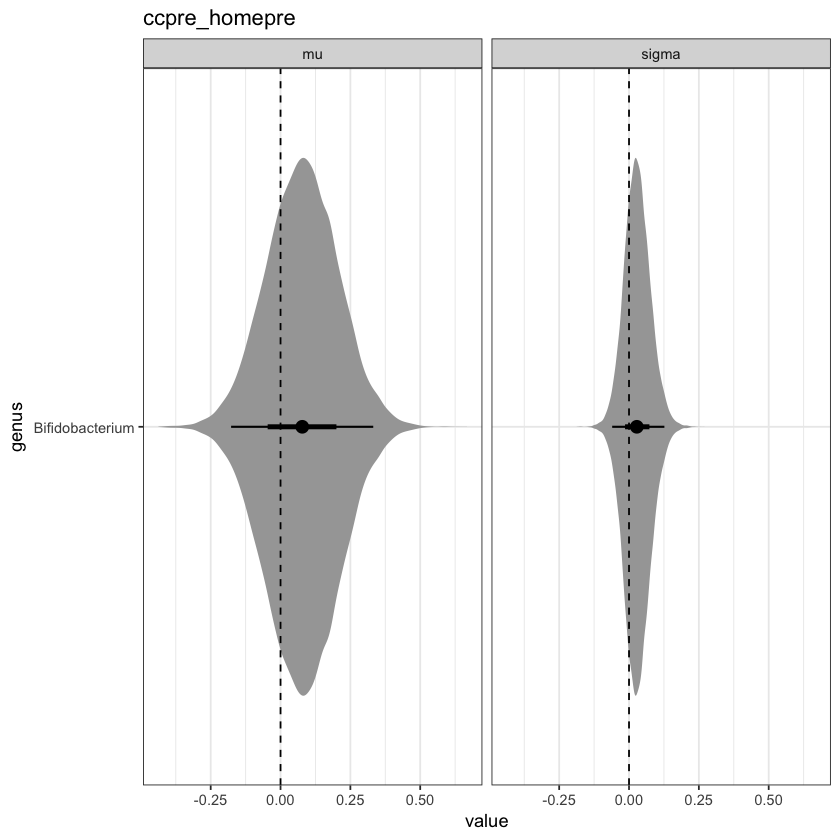

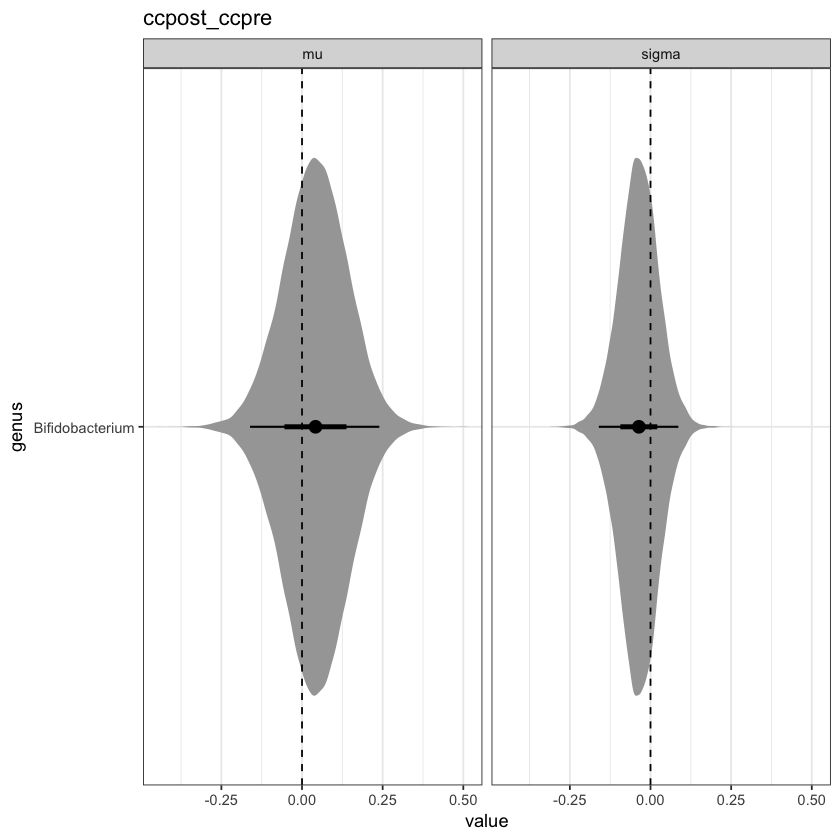

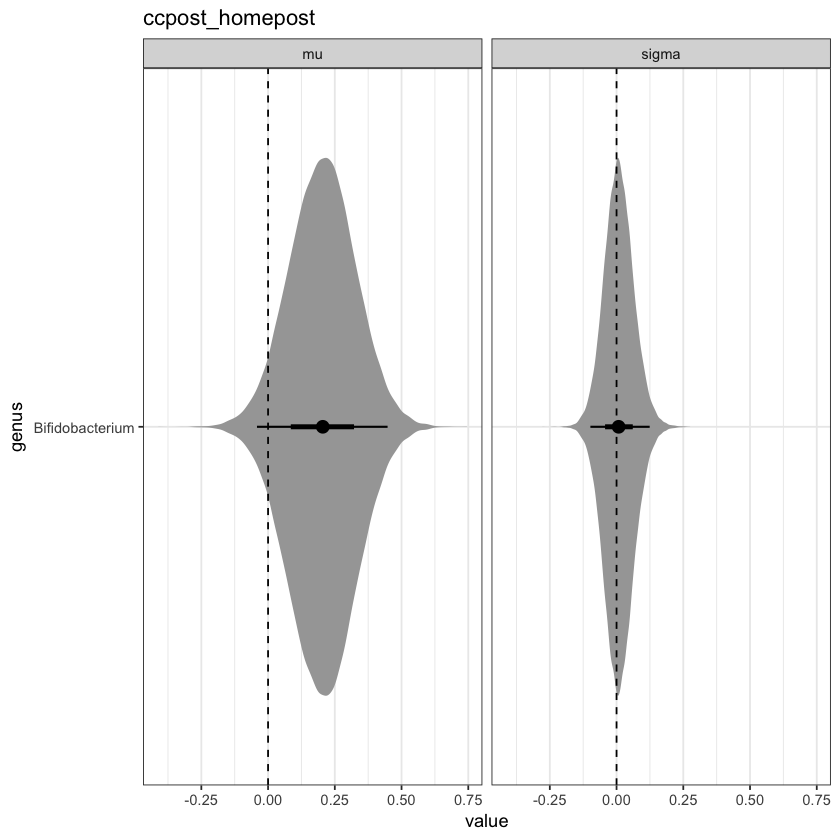

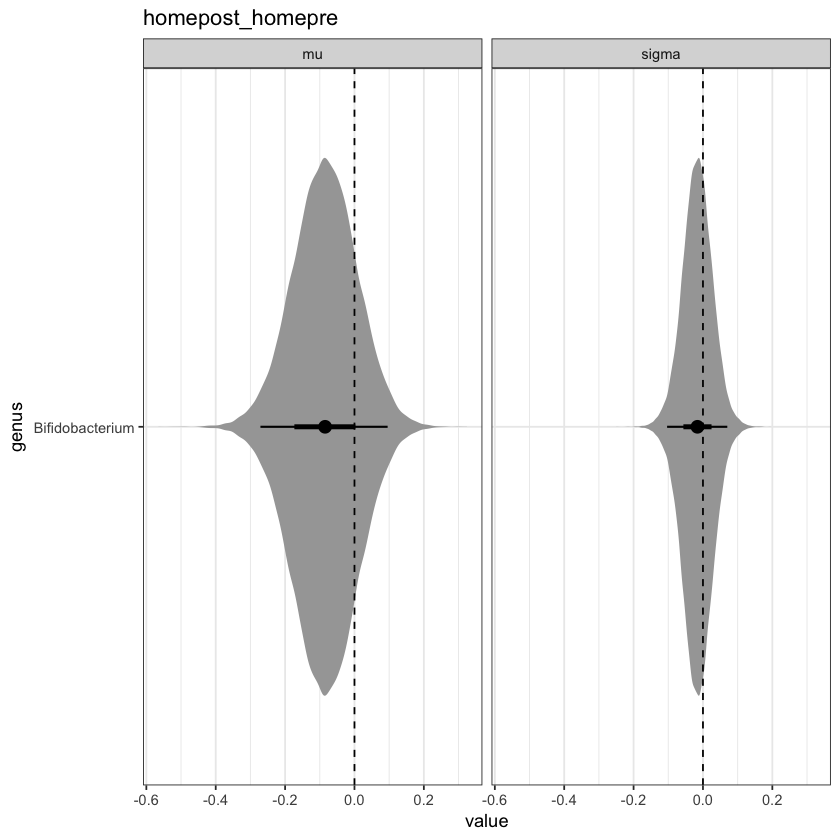

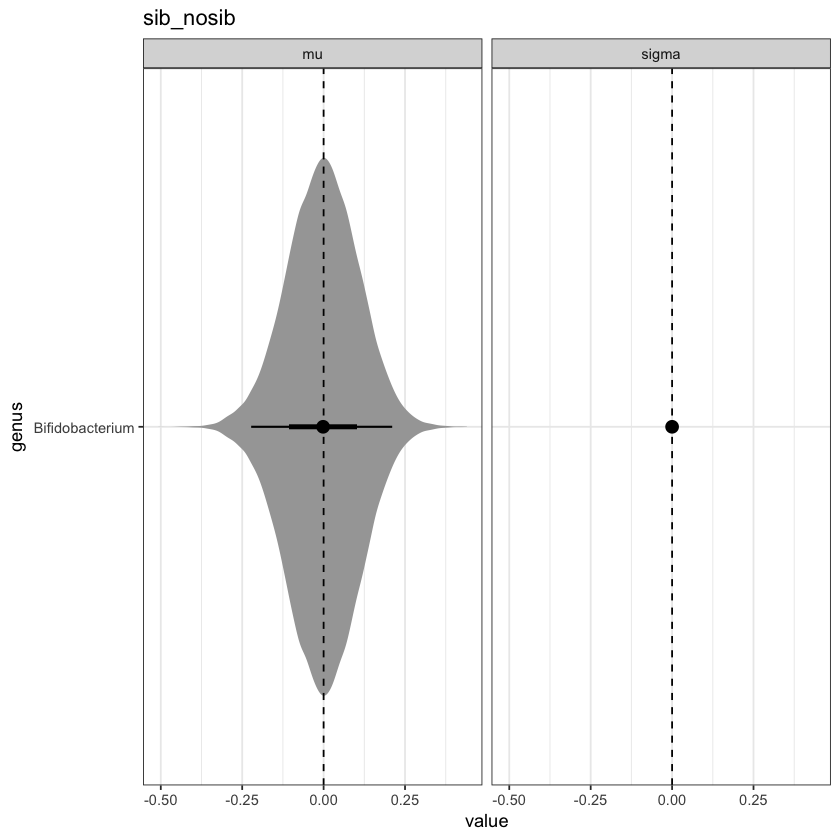

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


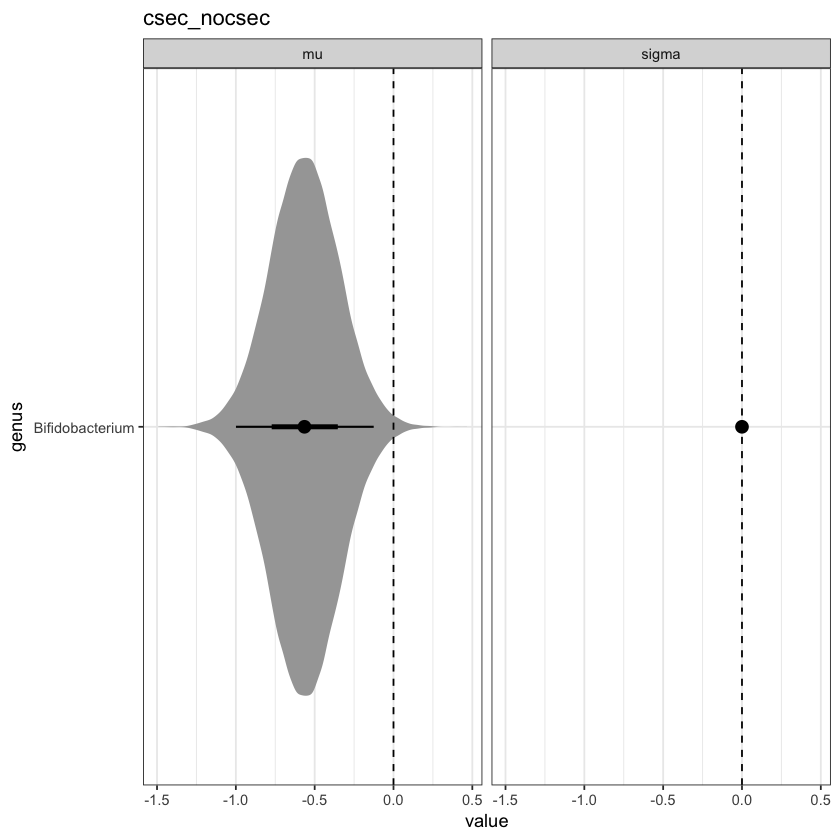

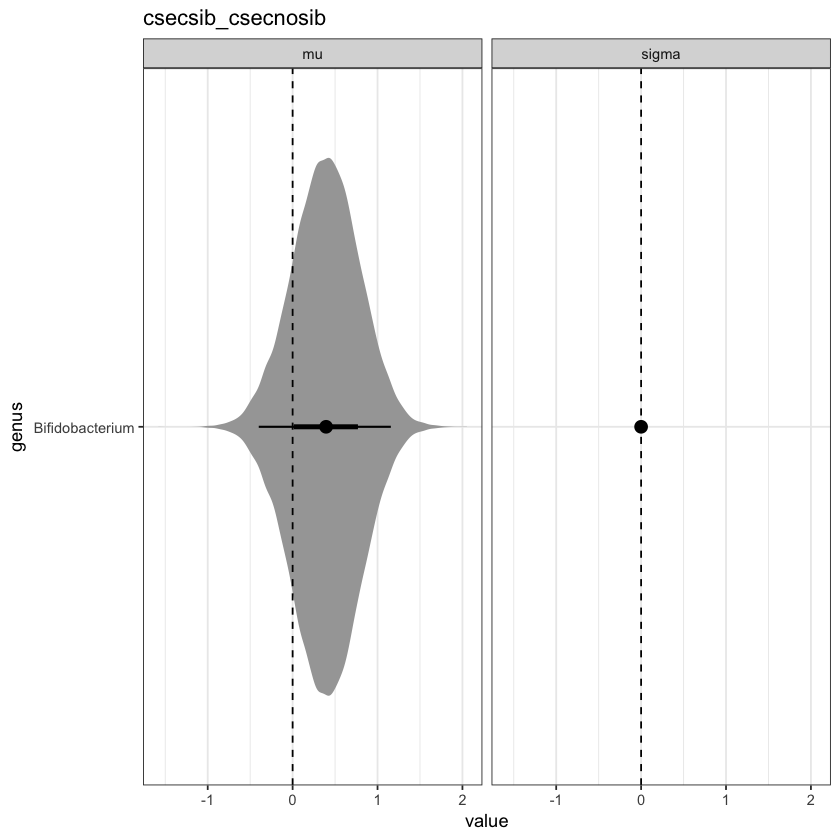

In [156]:
# for each comparison show mu_diff posterior distribution
map2(effects, comparisons_nest$comparison, function(df, comp) {
   comp_all %>% 
    gather(comparison, value, -genus, -dpar) %>%
    filter(comparison == comp, genus %in% df$genus) %>%
    ggplot(aes(value, genus)) +
    geom_eyeh() +
    geom_vline(aes(xintercept = 0), linetype = "dashed") +
    ggtitle(comp) +
    facet_wrap(~dpar) +
    theme_bw()
})

    

In [128]:
genera <- c("Bifidobacterium")

In [130]:
comparisons <- map(genera, function(genus) {
  
    # specify model
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit model
    fit <- brm_multiple(
        data = data_imp,
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = glue("{BIBO}/models/bayesian_student/student_sigma_{genus}")
    ) 
    
    # create a grid so we can get the mu for each subgroup
    nd <- with(data_imp[[1]], 
               expand.grid(cc = levels(cc), time = levels(time),
                           sibling = levels(sibling), csection = levels(csection)))
    # we use median value for bf
    nd$bf_count_s <- median(model.frame(fit)$bf_count_s)
    # it makes no sense that age remains similar when changing pre to post
    # so we use the median for pre and post
    nd <- nd %>% mutate(age_d_s = ifelse(time == "pre", -0.835, 0.626))
    
    # only add mu for genera if diagnostics are OK
    if (return_diag(fit, genus)) {
      
        # calulate mu for each subgroup
        plinp_mu <- posterior_linpred(fit, nd, transform = T,  re.form = ~ 0) %>% as_tibble()
        colnames(plinp_mu) <- c(
            "home_pre_nosib_nocsec",
            "cc_pre_nosib_nocsec",
            "home_post_nosib_nocsec",
            "cc_post_nosib_nocsec",
            "home_pre_sib_nocsec",
            "cc_pre_sib_nocsec",
            "home_post_sib_nocsec", 
            "cc_post_sib_nocsec",
            "home_pre_nosib_csec",
            "cc_pre_nosib_csec", 
            "home_post_nosib_csec",
            "cc_post_nosib_csec",
            "home_pre_sib_csec",
            "cc_pre_sib_csec",
            "home_post_sib_csec",
            "cc_post_sib_csec")
            
        # mu comparisons (csec group separately)
        mu_group <- plinp_mu %>%
            mutate(
                genus = genus, 
                
                # ccpre vs homepre 
                homepre = (home_pre_nosib_nocsec + home_pre_sib_nocsec)/2,
                ccpre = (cc_pre_nosib_nocsec + cc_pre_sib_nocsec)/2,
                ccpre_homepre = ccpre - homepre,
                
                # ccpost vs ccpre
                ccpost = (cc_post_nosib_nocsec + cc_post_sib_nocsec)/2,
                ccpost_ccpre = ccpost -ccpre,
                
                # ccpost vs homepost
                homepost = (home_post_nosib_nocsec + home_post_sib_nocsec)/2,
                ccpost_homepost = ccpost - homepost,
                
                # homepost vs homepre
                homepost_homepre = homepost - homepre,
                
                # sibling (if csec: home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)
                nosib = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec)/4,
                sib = (home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/4,
                sib_nosib = sib - nosib,
                
                # csec
                nocsec = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec +
                          home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/8,
                csec = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec +
                          home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/8,
                csec_nocsec = csec - nocsec,
                
                # sib * csec
                csec_sib = (home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/4,
                csec_nosib = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)/4,
                csecsib_csecnosib = csec_sib - csec_nosib
            ) %>%
        select(genus, ccpre_homepre, ccpost_ccpre, ccpost_homepost, homepost_homepre, sib_nosib, csec_nocsec, csecsib_csecnosib)
            
        
        
        # calulate sigma for each subgroup
        plinp_sigma <- posterior_linpred(fit, nd, transform = T,  re.form = ~ 0, dpar = "sigma") %>% as_tibble()
        colnames(plinp_sigma) <- c(
            "home_pre_nosib_nocsec",
            "cc_pre_nosib_nocsec",
            "home_post_nosib_nocsec",
            "cc_post_nosib_nocsec",
            "home_pre_sib_nocsec",
            "cc_pre_sib_nocsec",
            "home_post_sib_nocsec", 
            "cc_post_sib_nocsec",
            "home_pre_nosib_csec",
            "cc_pre_nosib_csec", 
            "home_post_nosib_csec",
            "cc_post_nosib_csec",
            "home_pre_sib_csec",
            "cc_pre_sib_csec",
            "home_post_sib_csec",
            "cc_post_sib_csec")
            
        # sigma comparisons (csec group separately)
        sigma_group <- plinp_sigma %>%
            mutate(
                genus = genus, 
                
                # ccpre vs homepre 
                homepre = (home_pre_nosib_nocsec + home_pre_sib_nocsec)/2,
                ccpre = (cc_pre_nosib_nocsec + cc_pre_sib_nocsec)/2,
                ccpre_homepre = ccpre - homepre,
                
                # ccpost vs ccpre
                ccpost = (cc_post_nosib_nocsec + cc_post_sib_nocsec)/2,
                ccpost_ccpre = ccpost -ccpre,
                
                # ccpost vs homepost
                homepost = (home_post_nosib_nocsec + home_post_sib_nocsec)/2,
                ccpost_homepost = ccpost - homepost,
                
                # homepost vs homepre
                homepost_homepre = homepost - homepre,
                
                # sibling (if csec: home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)
                nosib = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec)/4,
                sib = (home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/4,
                sib_nosib = sib - nosib,
                
                # csec
                nocsec = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec +
                          home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/8,
                csec = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec +
                          home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/8,
                csec_nocsec = csec - nocsec,
                
                # sib * csec
                csec_sib = (home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/4,
                csec_nosib = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)/4,
                csecsib_csecnosib = csec_sib - csec_nosib
            ) %>%
        select(genus, ccpre_homepre, ccpost_ccpre, ccpost_homepost, homepost_homepre, sib_nosib, csec_nocsec, csecsib_csecnosib)
        
        return(list(mu_group, sigma_group))
        
        
          
    } else {
        print(glue("{genus} excluded (diagnostics)"))
        exclude_vector <- c(exclude_vector, genus)
        return(NA)
    }
})

Fitting imputed model 1
Compiling the C++ model
recompiling to avoid crashing R session
Start sampling
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5
Fitting imputed model 6
Fitting imputed model 7
Fitting imputed model 8
Fitting imputed model 9
Fitting imputed model 10
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling


In [131]:
comparisons

genus,ccpre_homepre,ccpost_ccpre,ccpost_homepost,homepost_homepre,sib_nosib,csec_nocsec,csecsib_csecnosib
Bifidobacterium,-0.04292165,0.355101610,0.49130156,-0.179121602,-5.041258e-02,-0.6289544,0.325208753
Bifidobacterium,0.18358850,0.057163726,0.25157993,-0.010827699,-3.818738e-02,-0.4418598,0.258378054
Bifidobacterium,0.34430086,0.107059833,0.40763219,0.043728504,5.943220e-02,-0.5785671,-0.376327588
Bifidobacterium,-0.17830164,0.146161012,0.02466955,-0.056810178,9.013259e-02,-0.4056989,0.845228054
Bifidobacterium,-0.05620062,0.119671509,0.26450771,-0.201036824,9.148344e-03,-0.7155632,0.263165586
Bifidobacterium,0.16327409,-0.080742974,0.07442070,0.008110408,8.235224e-03,-0.4211304,0.015208262
Bifidobacterium,0.30452149,0.023475403,0.30156035,0.026436544,5.407421e-02,-0.5107957,0.335361805
Bifidobacterium,-0.02324364,0.214143424,0.23082517,-0.039925382,-2.114255e-02,-0.5905375,0.007970401
Bifidobacterium,0.20465849,-0.077485240,0.22641522,-0.099241967,1.647498e-02,-0.5838719,0.361410941
Bifidobacterium,0.17322365,0.060061494,0.46610436,-0.232819221,5.198089e-02,-0.6767501,0.141895593
